In [1]:
import os
import sys
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2 as cv
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, ELU
from keras.layers import Lambda, Dense, Dropout, Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.layers import ELU
from keras.optimizers import Adam
%matplotlib inline
# np.set_printoptions(threshold=sys.maxsize)

Using TensorFlow backend.


In [44]:
model_name = 'keras'
batch_size = 40
epoch_num = 20
steps_per_epoch = 400

asset_path = '../train/assets'
#train_name = f'model={model_name}_C24_C36_C48_D50_C64_C64_De100_De50_De10_De1-batch_size={batch_size}-num_epoch={epoch_num}-steps_per_epoch={steps_per_epoch}'
#train_name = f'model={model_name}2_elu_C40P_C20P_D25_De128_D30_De64_De15_De1-batch_size={batch_size}-num_epoch={epoch_num}-steps_per_epoch={steps_per_epoch}'
train_name = f'model={model_name}_elu_C40_C20_D25_De128_D30_De64_De15_De1-batch_size={batch_size}-num_epoch={epoch_num}-steps_per_epoch={steps_per_epoch}__3'
train_path = os.path.join(asset_path, train_name)

train_meta_loc = os.path.join(train_path, 'train_meta.csv')
test_meta_loc = os.path.join(train_path, 'test_meta.csv')
history_loc = os.path.join(train_path, 'history.p')
weights_loc = os.path.join(train_path, 'weights.h5')
tensorboard_loc = os.path.join(train_path, train_name)
print(history_loc, '\n', weights_loc, '\n', tensorboard_loc)

../train/assets/model=keras_elu_C40_C20_D25_De128_D30_De64_De15_De1-batch_size=40-num_epoch=20-steps_per_epoch=400__3/history.p 
 ../train/assets/model=keras_elu_C40_C20_D25_De128_D30_De64_De15_De1-batch_size=40-num_epoch=20-steps_per_epoch=400__3/weights.h5 
 ../train/assets/model=keras_elu_C40_C20_D25_De128_D30_De64_De15_De1-batch_size=40-num_epoch=20-steps_per_epoch=400__3/model=keras_elu_C40_C20_D25_De128_D30_De64_De15_De1-batch_size=40-num_epoch=20-steps_per_epoch=400__3


In [3]:
# Global Vars
img = (cv.imread('../train/photos/images/gray_Clipped/0.jpg')).shape
img_height = img[0]
img_width = img[1]
img_channels = img[2]
print(img, img_height, img_width, img_channels)

(136, 320, 3) 136 320 3


In [4]:
def adjust_Value(prvs_FRAME, curr_FRAME, HSV_value):
    prvs_FRAME = cv.cvtColor(prvs_FRAME, cv.COLOR_BGR2HSV)
    curr_FRAME = cv.cvtColor(curr_FRAME, cv.COLOR_BGR2HSV)
    prvs_FRAME[...,2] = prvs_FRAME[...,2]*HSV_value
    curr_FRAME[...,2] = curr_FRAME[...,2]*HSV_value
    return prvs_FRAME, curr_FRAME

In [5]:
def opticalFlow_DENSE(prvs_FRAME, curr_FRAME):
    # flow_mat = None
    # image_scale = 0.5
    # pyr_images = 1 # was 3
    # win_size = 15
    # pyr_iterations = 2 # was 3
    # poly_expans = 5
    # std = 1.3 # was 1.2
    
    flow_mat = None
    image_scale = 0.5
    pyr_images = 1 # was 3
    win_size = 10
    pyr_iterations = 2 # was 3
    poly_expans = 5
    std = 1.3 # was 1.2

    hsv = np.zeros_like(prvs_FRAME)
    hsv[...,1] = 255
    prvs_FRAME = cv.cvtColor(prvs_FRAME,cv.COLOR_BGR2GRAY)
    curr_FRAME = cv.cvtColor(curr_FRAME,cv.COLOR_BGR2GRAY)
    flow = cv.calcOpticalFlowFarneback(prvs_FRAME,curr_FRAME,flow_mat,image_scale,pyr_images,win_size,pyr_iterations,poly_expans,std,0)
    mag, ang = cv.cartToPolar(flow[...,0], flow[...,1])
    hsv[...,0] = ang*180/np.pi/2
    hsv[...,2] = cv.normalize(mag,None,0,255,cv.NORM_MINMAX)
    bgr = cv.cvtColor(hsv,cv.COLOR_HSV2BGR)
    return bgr

In [47]:
def getData(train_meta, kLoopCount, train_index, getSpeed):
    opt_flows = np.empty((0, img_height, img_width, img_channels), dtype='uint8')
    speed = np.empty((0))
    index = 1
    for k in range(kLoopCount):
        #print(index)
        HSV_value = np.random.uniform(low=.7, high=1.4)
        #print(train_index)
        curr_FRAME = cv.imread(train_meta['image_path'][train_index])
        #curr_FRAME = curr_FRAME[100:440, :-90]
        prvs_FRAME = cv.imread(train_meta['image_path'][train_index-1])
        #prvs_FRAME = prvs_FRAME[100:440, :-90]
        if getSpeed:
            speed = np.append(speed, train_meta['speed'][train_index])
        prvs_FRAME, curr_FRAME = adjust_Value(prvs_FRAME, curr_FRAME, HSV_value)
        opt_flow = opticalFlow_DENSE(prvs_FRAME, curr_FRAME)
        opt_flow.dtype = 'uint8'
        opt_flows = np.append(opt_flows, [opt_flow], axis=0)
        index = index + 1
    if getSpeed:
        return opt_flows, speed
    else:
        return opt_flows

In [48]:
def getTrainingData(train_meta, train_index, batchSize):
    global img_height, img_width, img_channels
    while True:
        opt_flow_arr = np.empty((0, img_height, img_width, img_channels))
        speed_arr = np.empty((0))
        index2 = 0
        for i in range(batchSize):
            #print(index2)
            index = np.random.randint(0, train_index.shape[0])
            opt_flow, speed = getData(train_meta, 1, train_index[index], True)
            opt_flow_arr = np.append(opt_flow_arr, opt_flow, axis=0)
            speed_arr = np.append(speed_arr, speed)
            index2 = index2 + 1
        #print(opt_flow_arr.shape)
        yield opt_flow_arr, speed_arr

In [50]:
def getValData(train_meta, val_index, batchSize, getSpeed):
    while True:
        index = 0
        for i in range(len(val_index)):
            if getSpeed:
                opt_flow, speed = getData(train_meta, 1, val_index[index], getSpeed)
            else:
                opt_flow = getData(train_meta, 1, val_index[index], getSpeed)
            #opt_flow_arr = np.append(opt_flow_arr, opt_flow)
            index = index + 1
            if getSpeed:
                yield opt_flow, speed
            else:
                yield opt_flow

In [9]:
def createCNNModel():
    model = Sequential()
    model.add(Conv2D(filters=40, kernel_size=(5,5), strides=(3,3), activation='elu', input_shape=(136,320,3)))
    #model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(filters=20, kernel_size=(5,5), strides=(2,2), activation='elu'))
    #model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(rate=0.25))
    model.add(Flatten())
    model.add(Dense(units=128, activation='elu'))
    model.add(Dropout(rate=0.3))
    model.add(Dense(units=64, activation='elu'))
    model.add(Dense(units=15, activation='elu'))
    model.add(Dense(units=1, activation='elu'))
    #adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(optimizer='adam', loss='mse')
    
#     model = Sequential()
#     # normalization    
#     # perform custom normalization before lambda layer in network
#     model.add(Lambda(lambda x: x/ 127.5 - 1, input_shape = (136,320,3)))

#     model.add(Conv2D(24, (5, 5), 
#                      strides=(2,2), 
#                      padding = 'valid',
#                      kernel_initializer = 'he_normal',
#                      name = 'conv1'))
    
    
#     model.add(ELU())    
#     model.add(Conv2D(36, (5, 5), 
#                      strides=(2,2), 
#                      padding = 'valid',
#                      kernel_initializer = 'he_normal',
#                      name = 'conv2'))
    
#     model.add(ELU())    
#     model.add(Conv2D(48, (5, 5), 
#                      strides=(2,2), 
#                      padding = 'valid',
#                      kernel_initializer = 'he_normal',
#                      name = 'conv3'))
#     model.add(ELU())
#     model.add(Dropout(0.5))
#     model.add(Conv2D(64, (3, 3), 
#                      strides = (1,1), 
#                      padding = 'valid',
#                      kernel_initializer = 'he_normal',
#                      name = 'conv4'))
    
#     model.add(ELU())              
#     model.add(Conv2D(64, (3, 3), 
#                      strides= (1,1), 
#                      padding = 'valid',
#                      kernel_initializer = 'he_normal',
#                      name = 'conv5'))
              
              
#     model.add(Flatten(name = 'flatten'))
#     model.add(ELU())
#     model.add(Dense(100, kernel_initializer = 'he_normal', name = 'fc1'))
#     model.add(ELU())
#     model.add(Dense(50, kernel_initializer = 'he_normal', name = 'fc2'))
#     model.add(ELU())
#     model.add(Dense(10, kernel_initializer = 'he_normal', name = 'fc3'))
#     model.add(ELU())
    
#     # do not put activation at the end because we want to exact output, not a class identifier
#     model.add(Dense(1, name = 'output', kernel_initializer = 'he_normal'))
    
#     adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
#     model.compile(optimizer = adam, loss = 'mse')
    
    return model

In [10]:
def start():
    global batch_size, epoch_num, steps_per_epoch, train_path
    train_csv_path = '../train/text/CSV'
    train_meta = pd.read_csv(os.path.join(train_csv_path, 'trainGrayClipped_meta.csv'))
    
    data_index = np.loadtxt('../train/text/train_val_index.txt', np.dtype('int16'), delimiter='\n')
    dataset_frames_num = train_meta.shape[0]
    train_frames_num = int(.6*(dataset_frames_num-1))
    val_frames_num = int(.5*(dataset_frames_num - train_frames_num))
    
    
    train_index = data_index[:train_frames_num]
    val_index = data_index[train_frames_num:(train_frames_num+val_frames_num)]
    print(train_index.shape, val_index.shape)
    
    if not os.path.exists(train_path):
        os.makedirs(train_path)
    
    valid_generator = getValData(train_meta, val_index, batch_size, True)
    val_size = len(val_index)
    earlyStopping = EarlyStopping(monitor='val_loss', 
                                  patience=3, 
                                  verbose=1, 
                                  min_delta = 0.23,
                                  mode='min',)
    
    modelCheckpoint = ModelCheckpoint(weights_loc, 
                                      monitor = 'val_loss', 
                                      save_best_only = True, 
                                      mode = 'min', 
                                      verbose = 1,
                                     save_weights_only = True)
    
    tensorboard = TensorBoard(log_dir=tensorboard_loc, histogram_freq=0,
                                write_graph=True, write_images=True)
    callbacks_list = [modelCheckpoint, tensorboard, earlyStopping]
    
    model = createCNNModel()
    
    train_size = len(train_index)
    train_generator = getTrainingData(train_meta, train_index, batch_size)
    history = model.fit_generator(
            train_generator, 
            steps_per_epoch = steps_per_epoch, 
            epochs = epoch_num,
            callbacks = callbacks_list,
            verbose = 1,
            validation_data = valid_generator,
            validation_steps = val_size)

    print(history)
    pickle.dump(history.history, open(history_loc, "wb"))
    
    return model, history.history, valid_generator, val_size

In [11]:
model, history, valid_generator, val_size = start()

(12239,) (4080,)
Epoch 1/20
400/400 [==============================] - 248s 620ms/step - loss: 21.8356 - val_loss: 2.4734

Epoch 00001: val_loss improved from inf to 2.47337, saving model to ../train/assets/model=keras_elu_C40_C20_D25_De128_D30_De64_De15_De1-batch_size=40-num_epoch=20-steps_per_epoch=400__3/weights.h5
Epoch 2/20
400/400 [==============================] - 242s 606ms/step - loss: 11.1368 - val_loss: 0.1731

Epoch 00002: val_loss improved from 2.47337 to 0.17310, saving model to ../train/assets/model=keras_elu_C40_C20_D25_De128_D30_De64_De15_De1-batch_size=40-num_epoch=20-steps_per_epoch=400__3/weights.h5
Epoch 3/20
400/400 [==============================] - 243s 607ms/step - loss: 9.6371 - val_loss: 0.0019

Epoch 00003: val_loss improved from 0.17310 to 0.00192, saving model to ../train/assets/model=keras_elu_C40_C20_D25_De128_D30_De64_De15_De1-batch_size=40-num_epoch=20-steps_per_epoch=400__3/weights.h5
Epoch 4/20
400/400 [==============================] - 243s 607ms/st

In [ ]:
#history = pickle.load(open(history_loc, "rb" ))
model = createCNNModel()
model.load_weights(weights_loc)
adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(optimizer = adam, loss = 'mse')

In [32]:
train_csv_path = '../train/text/CSV'
train_meta = pd.read_csv(os.path.join(train_csv_path, 'trainGrayClipped_meta.csv'))

data_index = np.loadtxt('../train/text/train_val_index.txt', np.dtype('int16'), delimiter='\n')
dataset_frames_num = train_meta.shape[0]
#train_frames_num = int(.8*(dataset_frames_num-1))
train_frames_num = int(.6*(dataset_frames_num-1))
val_frames_num = int(.5*((dataset_frames_num-1) - train_frames_num))
test_frames_num = int(((dataset_frames_num-1) - (train_frames_num + val_frames_num)))
print(train_frames_num, val_frames_num, test_frames_num)

train_index = data_index[:train_frames_num]
val_index = data_index[train_frames_num:(train_frames_num+val_frames_num)]
test_index = data_index[(train_frames_num+val_frames_num):]
valid_generator = getValData(train_meta, val_index, batch_size, True)
test_generator = getValData(train_meta, test_index, batch_size, True)
val_size = len(val_index)
test_size = len(test_index)

12239 4080 4080


In [35]:
val_score = model.evaluate(valid_generator, steps=val_size)
print('val score:', val_score)

4080/4080 [==============================] - 42s 10ms/step
val score: 4.0107035636901855


In [36]:
test_score = model.evaluate(test_generator, steps=test_size)
print('test score:', test_score)

4080/4080 [==============================] - 42s 10ms/step
test score: 0.06530343741178513


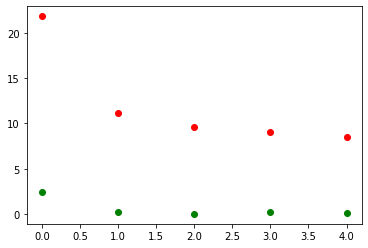

In [41]:
plt.plot(history['loss'], 'ro')
plt.plot(history['val_loss'], 'go')

In [ ]:
fig_size = plt.rcParams["figure.figsize"]
print(fig_size)
fig_size[0] = 30
fig_size[1] = 30
plt.rcParams["figure.figsize"] = fig_size
fig_size2 = plt.rcParams["figure.figsize"]
print(fig_size2)

In [ ]:
train_csv_path = '../train/text/CSV'
train_meta = pd.read_csv(os.path.join(train_csv_path, 'trainGrayClipped_meta.csv'))

data_index = np.loadtxt('../train/text/train_val_index.txt', np.dtype('int16'), delimiter='\n')
dataset_frames_num = train_meta.shape[0]
train_frames_num = int(.70*(dataset_frames_num-1))

train_index = data_index[:train_frames_num]
val_index = data_index[train_frames_num:]
print(train_index, val_index)
plt.plot(train_meta['speed'][train_index], 'ro')
plt.plot(train_meta['speed'][val_index], 'go')

In [52]:
def predictSpeed(a_meta, a_meta_loc, getSpeed):
    global train_meta_loc, test_meta_loc, batch_size, weights_loc

    dataset_frames_num = a_meta.shape[0]
    print(dataset_frames_num)
    
    data_index = np.arange(1, (dataset_frames_num))
    data_length = data_index.shape[0]
    
    data_gen = getValData(a_meta, data_index, batch_size, getSpeed)
    
    model = createCNNModel()
    model.load_weights(weights_loc)
    predicted_speed = model.predict(data_gen, steps=data_length, verbose=1)
    
    a_meta = a_meta.assign(predicted_speed=pd.Series(np.empty((20400))).values)
    a_meta = a_meta.assign(error=pd.Series(np.empty((20400))).values)
    a_meta.loc[:]['predicted_speed'] = np.nan
    a_meta.loc[1:,'predicted_speed'] = predicted_speed
    a_meta.loc[:]['error'] = np.nan
    a_meta.loc[1:,'error'] = abs(a_meta.loc['speed'][1:] - predicted_speed)
    a_meta.to_csv(a_meta_loc, index=False)

In [53]:
predictSpeed(train_meta, train_meta_loc, False)

20400
20399/20399 [==============================] - 208s 10ms/step


In [54]:
train_meta = pd.read_csv(train_meta_loc)

In [73]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(train_meta[:1000])

,image_path,image_index,speed,predicted_speed,error
0,../train/photos/images/gray_Clipped/0.jpg,0,28.105569,NaN,NaN
1,../train/photos/images/gray_Clipped/1.jpg,1,28.105569,23.180176,4.925393
2,../train/photos/images/gray_Clipped/2.jpg,2,28.106527,26.144821,1.961706
3,../train/photos/images/gray_Clipped/3.jpg,3,28.130404,26.040251,2.090153
4,../train/photos/images/gray_Clipped/4.jpg,4,28.109243,21.423214,6.686029
5,../train/photos/images/gray_Clipped/5.jpg,5,28.088572,22.595806,5.492766
6,../train/photos/images/gray_Clipped/6.jpg,6,28.034211,23.970972,4.063239
7,../train/photos/images/gray_Clipped/7.jpg,7,28.018491,21.579773,6.438718
8,../train/photos/images/gray_Clipped/8.jpg,8,27.986624,20.360416,7.626208
9,../train/photos/images/gray_Clipped/9.jpg,9,28.016352,23.088667,4.927685


In [58]:
import sys
np.set_printoptions(threshold=sys.maxsize)

In [69]:
train_meta = train_meta.assign(error=pd.Series(np.empty((20400))).values)
train_meta.loc[:]['error'] = np.nan
train_meta.loc[1:,'error'] = abs(train_meta.loc[1:, 'speed'] - train_meta.loc[1:,'predicted_speed'])

In [70]:
train_meta.head()

,image_path,image_index,speed,predicted_speed,error
0,../train/photos/images/gray_Clipped/0.jpg,0,28.105569,NaN,NaN
1,../train/photos/images/gray_Clipped/1.jpg,1,28.105569,23.180176,4.925393
2,../train/photos/images/gray_Clipped/2.jpg,2,28.106527,26.144821,1.961706
3,../train/photos/images/gray_Clipped/3.jpg,3,28.130404,26.040251,2.090153
4,../train/photos/images/gray_Clipped/4.jpg,4,28.109243,21.423214,6.686029


In [72]:
train_meta.to_csv(train_meta_loc, index=False)